# 7. 순환 신경망
## 7.3 Bi-LSTM
CNN이 아닌, 시퀀스를 처리하기에 좋은 RNN계열 모델을 활용해서도 이미지를 처리할 수 있다.

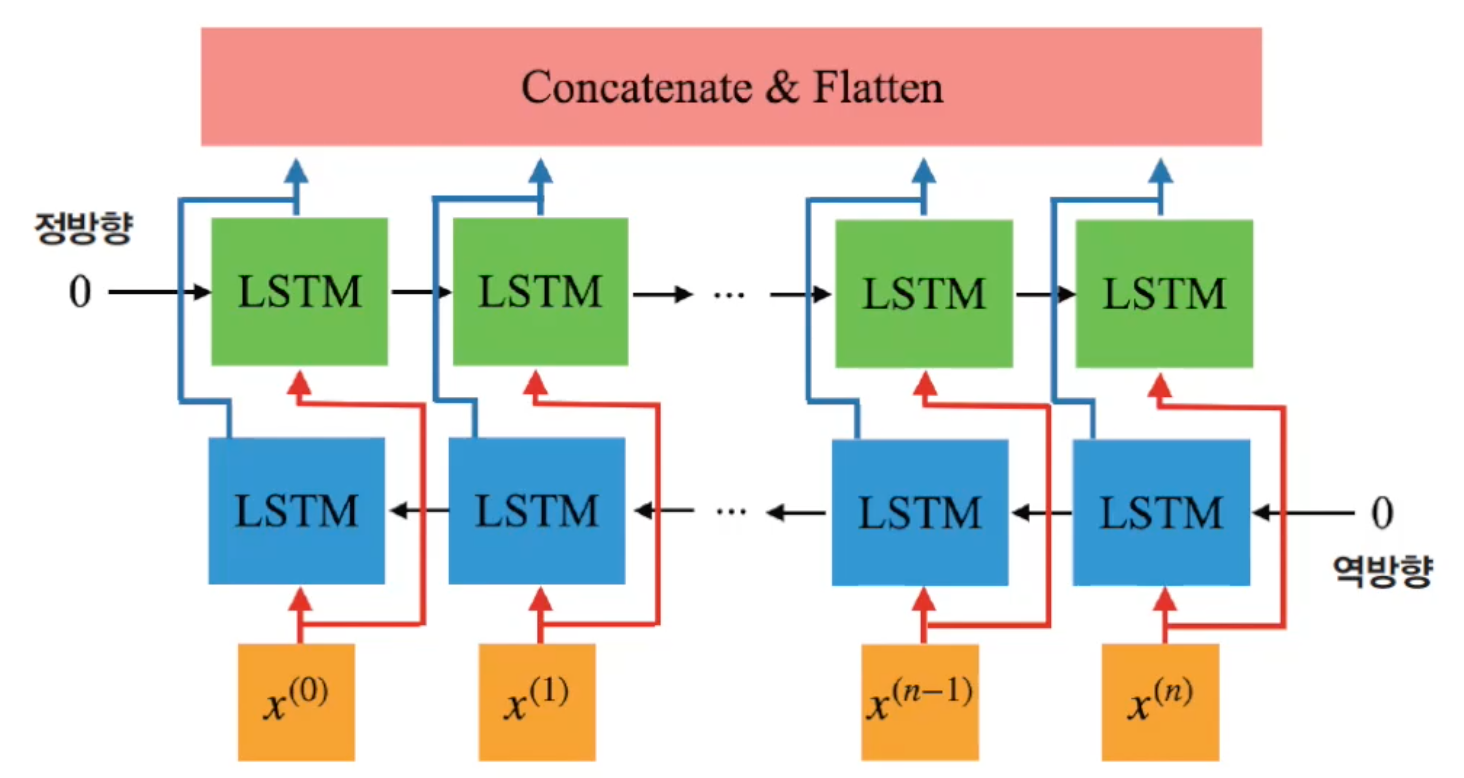

In [1]:
import torch
import torchvision
import torch.nn as nn 
import torch.optim as optim  
from torch.utils.data import DataLoader

In [2]:
# Load Data
tensor_mode = torchvision.transforms.ToTensor()
trainset = torchvision.datasets.MNIST(root="./data", train=True, transform=tensor_mode, download=True)
testset = torchvision.datasets.MNIST(root="./data", train=False, transform=tensor_mode, download=True)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
print(len(trainloader))
print(len(testloader))

469
79


In [3]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length, num_classes, device):
        super(BiLSTM, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        #self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.fc = nn.Linear(seq_length*hidden_size * 2, num_classes) #분류기 역할을 하는 fc레이어

    def forward(self, x):
       #히든 스테이트와 셀스테이트가 2배로 있어야한다. 정방향과 역방향을 커버하기 위해서
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device)
        out, _ = self.lstm(x, (h0, c0)) #out값에는 정방향과 역방향 데이터가 concat되어서 나온다.
        #out = self.fc(out[:, -1, :])
        out = out.reshape(-1,self.seq_length*self.hidden_size * 2) #여기서도 2배를 해준다. 하나로 피는 과정에서
        out = self.fc(out)
        return out

In [8]:
#Mnist데이터는 28 X 28의 데이터인데, 이걸 각 열기준으로 짤라서 활용한다.
#크기가 28인 시퀀스 벡터 28개가 생성이된다.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sequence_length = trainset.data.size(1) #각 열. 28. 시퀀스 길이라고 생각하면됨
input_size = trainset.data.size(2) #각 행. 28이 나온다. 즉 피쳐라고 생각하면됨
num_layers = 2
hidden_size = 12
num_classes = 10

print(sequence_length)
print(input_size)
print(trainset.data.size())
print(testset.data.size())

28
28
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [9]:
model = BiLSTM(input_size, hidden_size, num_layers, sequence_length, num_classes, device)
model = model.to(device)   

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-3)

In [11]:
for epoch in range(11):
    correct = 0
    total = 0
    for data in trainloader:
        optimizer.zero_grad()
        inputs, labels = data[0].to(device).squeeze(1), data[1].to(device)  #input데이터는 squeeze를 활용해 2차원을 1차원으로 만듬
        outputs = model(inputs)
        loss = criterion(outputs, labels)        
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.detach(), 1) #각 Low별 최고 값을 뽑아낸다. 앞에 _ 는 배치의 개수를 담는 변수인데 사용할 필요가 없어서 _로 표시
        total += labels.size(0) #전체 원소의 개수 반환해서 total 변수에 더한다.
        correct += (predicted == labels).sum().item()

    print('[%d] train acc: %.2f' %(epoch, 100*correct/total))     

[0] train acc: 91.84
[1] train acc: 97.51
[2] train acc: 98.17
[3] train acc: 98.43
[4] train acc: 98.66
[5] train acc: 98.82
[6] train acc: 98.96
[7] train acc: 99.13
[8] train acc: 99.17
[9] train acc: 99.19
[10] train acc: 99.30


In [12]:
def accuracy(dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            inputs, labels = data[0].to(device).squeeze(1), data[1].to(device)      
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)      
            correct += (predicted == labels).sum().item()

    acc = 100*correct/total
    model.train()
    return acc

In [13]:
train_acc = accuracy(trainloader)
test_acc = accuracy(testloader)
print("Train Acc: %.1f, Test Acc: %.1f" %(train_acc, test_acc))

Train Acc: 99.4, Test Acc: 98.5
